In [65]:
import numpy as np
import pandas as pd
import pickle
import time

from sklearn.model_selection import train_test_split

from text_models import TextClassifier, extract_text_blocks, tokenize_data, load_glove_embedding
from lstm_attention_model import AttentionLSTM, train_part, evaluate, predict_labels
from helper import Dataset, plot_graphs, progress_bar, consolidate_results
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Dataset 

The dataset is a pandas dataframe with two columns: Text labels and the text sentences and sub-sentences. There are 8 different categories(labels) in total. Each sentence could also have multiple categories(labels) associated with it.

In [2]:
df = pickle.load( open( "review_labelled.pkl", "rb" ))

In [3]:
df.sample(10)

,label,pp_sent
17309,[salary_benefits],employee stock purchase plan
5920,[salary_benefits],onsite gym
5236,[salary_benefits],full medical dental vision benefits at no cost...
23513,[tech_product],legacy code bases are a challenge but things a...
4238,[wlb_working_conditions],excellent work life balance
25697,[wlb_working_conditions],work life balance
86850,"[management, culture_team]",no micro managing
70645,[Job Security/Advancement],career development frameworks
23862,[culture_team],some of my co workers have become some of my b...
51229,[Job Security/Advancement],you 'll have plenty of opportunity to grow here


Check for category imbalances in our dataset. Dataset looks well balanced in this case.

In [4]:
from collections import Counter
label_count = Counter([category for sublist in df.label.to_numpy() for category in sublist])
label_count

Counter({'Job Security/Advancement': 1151,
         'business_vision_competitors': 1042,
         'culture_team': 1148,
         'wlb_working_conditions': 1013,
         'salary_benefits': 1019,
         'management': 1064,
         'tech_product': 1009,
         'haras_discrim_sexism': 1001})

In [66]:
# This variable holds the test results for all the models for later comparison.
model_results = []

# Train LSTM

Train a Multilabel text classifier using LSTM. This model has the following architecture: <br>
Input -> Word Embedding Layer -> LSTM -> Spatial Dropout -> Fully Connected -> RELU -> Fully Connected -> Sigmoid <br>
Here the LSTM output to the next fully connected layer is from the last time step only. All the model implementations could be found at text_models.py

In [6]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_lstm = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

history_lstm = model_lstm.train(X_train, y_train, 'LSTM', epochs = 10)
model_lstm.model.summary()

W0215 14:47:01.751799 4687252928 deprecation.py:506] From /Users/kshitijsharma/Documents/CS231n/assignment2/.env/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Shape of data tensor: (8000,)
Found 3796 unique tokens.
Train on 4800 samples, validate on 1600 samples
Epoch 1/10
4800/4800 [==============================] - 16s 3ms/sample - loss: 0.4324 - binary_accuracy: 0.8630 - val_loss: 0.3869 - val_binary_accuracy: 0.8682
Epoch 2/10
4800/4800 [==============================] - 14s 3ms/sample - loss: 0.3684 - binary_accuracy: 0.8685 - val_loss: 0.3193 - val_binary_accuracy: 0.8769
Epoch 3/10
4800/4800 [==============================] - 14s 3ms/sample - loss: 0.2625 - binary_accuracy: 0.8940 - val_loss: 0.2062 - val_binary_accuracy: 0.9273
Epoch 4/10
4800/4800 [==============================] - 14s 3ms/sample - loss: 0.1600 - binary_accuracy: 0.9495 - val_loss: 0.1126 - val_binary_accuracy: 0.9715
Epoch 5/10
4800/4800 [==============================] - 14s 3ms/sample - loss: 0.0941 - binary_accuracy: 0.9738 - val_loss: 0.0876 - val_binary_accuracy: 0.9746
Epoch 6/10
4800/4800 [==============================] - 14s 3ms/sample - loss: 0.0608 - bin

Evaluate Model

In [7]:
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_lstm))
print('Test Accuracy: {}'.format(test_acc_lstm))

1600/1600 [==============================] - 1s 580us/sample - loss: 0.0561 - binary_accuracy: 0.9835
Test Loss: 0.056071516294032335
Test Accuracy: 0.9835156202316284


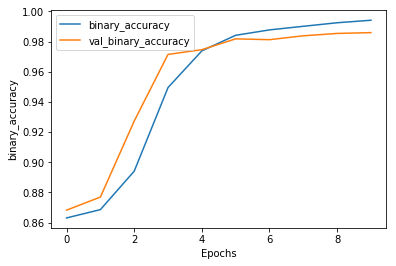

In [8]:
plot_graphs(history_lstm.history, 'binary_accuracy')

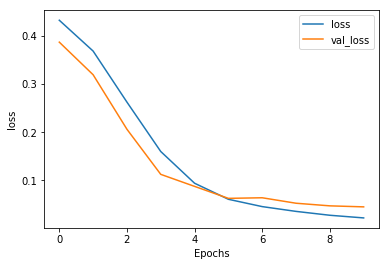

In [9]:
plot_graphs(history_lstm.history, 'loss')

In [67]:
h_lstm = consolidate_results(history_lstm.history, test_loss_lstm, test_acc_lstm, 'binary_accuracy', 'LSTM')
model_results.append(h_lstm)

# Train CNN

Model Architecture: <br> Input -> Word Embedding Layer -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid 

In [11]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_cnn = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

history_cnn = model_cnn.train(X_train, y_train, 'CNN', epochs = 10)
model_cnn.model.summary()

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Train on 4800 samples, validate on 1600 samples
Epoch 1/10
4800/4800 [==============================] - 2s 383us/sample - loss: 0.4451 - binary_accuracy: 0.8584 - val_loss: 0.3551 - val_binary_accuracy: 0.8682
Epoch 2/10
4800/4800 [==============================] - 2s 342us/sample - loss: 0.2547 - binary_accuracy: 0.9005 - val_loss: 0.1342 - val_binary_accuracy: 0.9553
Epoch 3/10
4800/4800 [==============================] - 2s 346us/sample - loss: 0.0737 - binary_accuracy: 0.9776 - val_loss: 0.0498 - val_binary_accuracy: 0.9847
Epoch 4/10
4800/4800 [==============================] - 2s 347us/sample - loss: 0.0305 - binary_accuracy: 0.9909 - val_loss: 0.0334 - val_binary_accuracy: 0.9900
Epoch 5/10
4800/4800 [==============================] - 2s 345us/sample - loss: 0.0166 - binary_accuracy: 0.9958 - val_loss: 0.0268 - val_binary_accuracy: 0.9915
Epoch 6/10
4800/4800 [==============================] - 2s 346us/sample - loss: 0.0098

Evaluate CNN Model

In [12]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_cnn))
print('Test Accuracy: {}'.format(test_acc_cnn))

1600/1600 [==============================] - 0s 72us/sample - loss: 0.0255 - binary_accuracy: 0.9917
Test Loss: 0.02548092878423631
Test Accuracy: 0.9917187690734863


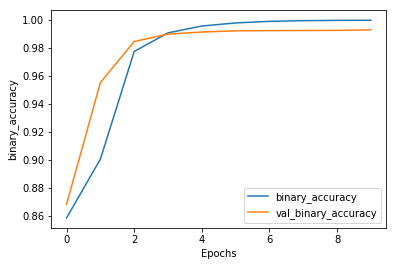

In [13]:
plot_graphs(history_cnn.history, 'binary_accuracy')

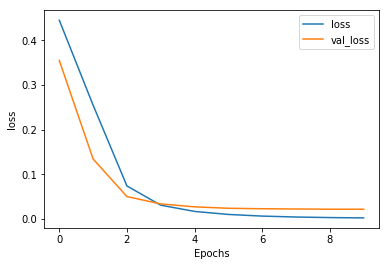

In [14]:
plot_graphs(history_cnn.history, 'loss')

In [68]:
h_cnn = consolidate_results(history_cnn.history, test_loss_cnn, test_acc_cnn, 'binary_accuracy', 'CNN')
model_results.append(h_cnn)

# Train CNN Glove

Model Architecture: 
Input -> GLoVe Word Embedding(Non trainable)  -> Convolution Layer -> RELU -> Global Max Pool -> Fully Connected -> Sigmoid

In [16]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_cnn_glove = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

history_cnn_glove = model_cnn_glove.train(X_train, y_train, 'CNN_Glove', epochs = 10)
model_cnn_glove.model.summary()

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Train on 4800 samples, validate on 1600 samples
Epoch 1/10
4800/4800 [==============================] - 1s 304us/sample - loss: 0.2759 - binary_accuracy: 0.8997 - val_loss: 0.1594 - val_binary_accuracy: 0.9495
Epoch 2/10
4800/4800 [==============================] - 1s 267us/sample - loss: 0.1189 - binary_accuracy: 0.9616 - val_loss: 0.1032 - val_binary_accuracy: 0.9670
Epoch 3/10
4800/4800 [==============================] - 1s 266us/sample - loss: 0.0785 - binary_accuracy: 0.9755 - val_loss: 0.0795 - val_binary_accuracy: 0.9754
Epoch 4/10
4800/4800 [==============================] - 1s 267us/sample - loss: 0.0566 - binary_accuracy: 0.9833 - val_loss: 0.0666 - val_binary_accuracy: 0.9794
Epoch 5/10
4800/4800 [==============================] - 1s 265us/sample - loss: 0.0419 - binary_accuracy: 0.9889 - val_loss: 0.0586 - val_binary_accuracy: 0.9819
Epoch 6/10
4800/4800 [==============================] - 1s 265us/sample - loss: 0.0317

Evaluate Glove Model

In [17]:
test_loss_glove, test_acc_glove = model_cnn_glove.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_glove))
print('Test Accuracy: {}'.format(test_acc_glove))

1600/1600 [==============================] - 0s 92us/sample - loss: 0.0452 - binary_accuracy: 0.9841
Test Loss: 0.045195553805679085
Test Accuracy: 0.9840624928474426


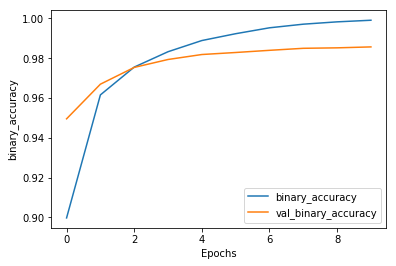

In [18]:
plot_graphs(history_cnn_glove.history, 'binary_accuracy')

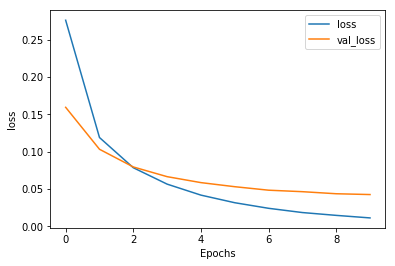

In [19]:
plot_graphs(history_cnn_glove.history, 'loss')

In [72]:
h_glove = consolidate_results(history_cnn_glove.history, test_loss_glove,
                           test_acc_glove, 'binary_accuracy', 'CNN GLoVe')
model_results.append(h_glove)

# Train MLP

Model Architecture: <br>
Input -> Word Embedding Layer -> 4x(Fully Connected -> RELU) -> Fully Connected -> Sigmoid <br>

In [21]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
model_mlp = TextClassifier(tokenizer, label_index)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

history_mlp = model_mlp.train(X_train, y_train, 'MLP', epochs = 10)
model_mlp.model.summary()

Shape of data tensor: (8000,)
Found 3796 unique tokens.
Train on 4800 samples, validate on 1600 samples
Epoch 1/10
4800/4800 [==============================] - 1s 117us/sample - loss: 3.3193 - binary_accuracy: 0.7809 - val_loss: 1.0439 - val_binary_accuracy: 0.8550
Epoch 2/10
4800/4800 [==============================] - 0s 46us/sample - loss: 1.0521 - binary_accuracy: 0.8302 - val_loss: 0.8413 - val_binary_accuracy: 0.8647
Epoch 3/10
4800/4800 [==============================] - 0s 44us/sample - loss: 0.8423 - binary_accuracy: 0.8526 - val_loss: 0.7531 - val_binary_accuracy: 0.8677
Epoch 4/10
4800/4800 [==============================] - 0s 45us/sample - loss: 0.7332 - binary_accuracy: 0.8638 - val_loss: 0.6680 - val_binary_accuracy: 0.8681
Epoch 5/10
4800/4800 [==============================] - 0s 44us/sample - loss: 0.6539 - binary_accuracy: 0.8670 - val_loss: 0.6171 - val_binary_accuracy: 0.8681
Epoch 6/10
4800/4800 [==============================] - 0s 44us/sample - loss: 0.6105 - bi

Evaluate MLP Model

In [22]:
test_loss_mlp, test_acc_mlp = model_mlp.evaluate(X_test,y_test)
print('Test Loss: {}'.format(test_loss_mlp))
print('Test Accuracy: {}'.format(test_acc_mlp))

1600/1600 [==============================] - 0s 26us/sample - loss: 0.5068 - binary_accuracy: 0.8683
Test Loss: 0.5067953461408615
Test Accuracy: 0.8682812452316284


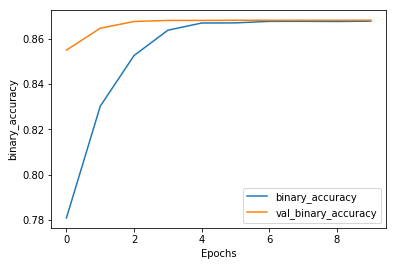

In [23]:
plot_graphs(history_mlp.history, 'binary_accuracy')

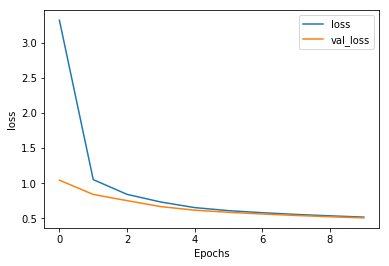

In [24]:
plot_graphs(history_mlp.history, 'loss')

In [69]:
h_mlp = consolidate_results(history_mlp.history, test_loss_mlp, test_acc_mlp, 'binary_accuracy', 'MLP')
model_results.append(h_mlp)

# LSTM with Attention

Model Architecture: 
Input -> Word Embedding Layer -> Bi-LSTM -> Attention layer -> Fully Connected -> Sigmoid 

In [74]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
# Split data into batches of 64
train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=True)
test_dset = Dataset(X_test, y_test, batch_size=64)

Shape of data tensor: (8000,)
Found 3796 unique tokens.


Train Attention model

In [75]:
sequence_length = 100
embedding_dim = 50
model_attention = AttentionLSTM(sequence_length, embedding_dim)

history_attention = train_part(model_attention, train_dset, val_dset, num_epochs=10, is_training=True)

Epoch 1, Loss: 0.4598977565765381, Accuracy: 85.05729675292969, Val Loss: 0.3897843658924103, Val Accuracy: 86.8203125
Epoch 2, Loss: 0.40348681807518005, Accuracy: 86.80989837646484, Val Loss: 0.38837170600891113, Val Accuracy: 86.8203125
Epoch 3, Loss: 0.3867248296737671, Accuracy: 86.83854675292969, Val Loss: 0.33943942189216614, Val Accuracy: 86.8203125
Epoch 4, Loss: 0.28682664036750793, Accuracy: 88.62760925292969, Val Loss: 0.20250919461250305, Val Accuracy: 92.21875
Epoch 5, Loss: 0.17050661146640778, Accuracy: 94.796875, Val Loss: 0.12690795958042145, Val Accuracy: 96.671875
Epoch 6, Loss: 0.13435079157352448, Accuracy: 96.36197662353516, Val Loss: 0.11699743568897247, Val Accuracy: 96.71875
Epoch 7, Loss: 0.10407540202140808, Accuracy: 97.49739837646484, Val Loss: 0.09015937149524689, Val Accuracy: 97.546875
Epoch 8, Loss: 0.07703714072704315, Accuracy: 98.35416412353516, Val Loss: 0.08125428110361099, Val Accuracy: 97.765625
Epoch 9, Loss: 0.06304597109556198, Accuracy: 98.8

Evaluate model

In [76]:
test_loss_attention, test_acc_attention = evaluate(model_attention, test_dset)
print('Test Loss: {}'.format(test_loss_attention))
print('Test Accuracy: {}'.format(test_acc_attention))

Test Loss: 0.07230759412050247
Test Accuracy: 0.9799218773841858


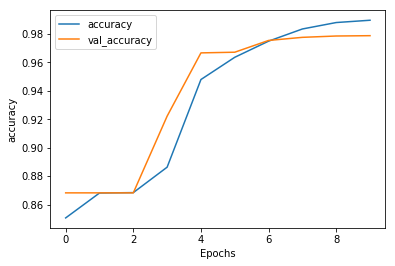

In [77]:
plot_graphs(history_attention, 'accuracy')

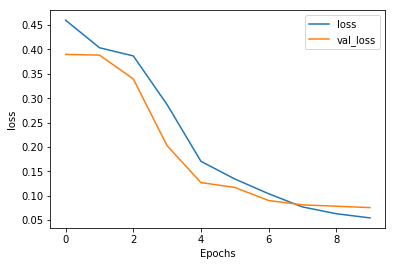

In [78]:
plot_graphs(history_attention, 'loss')

In [79]:
h_attention = consolidate_results(history_attention, test_loss_attention, test_acc_attention, 'accuracy', 'LSTM Attention')
model_results.append(h_attention)

# Comparison

Here before cross validation we can see LSTM, CNN, CNN Glove, LSTM Attention have very similar test accuracies. <br>
At this point we haven't done any cross validation so Val Accuracy and Test Accuracy have similar meaning.

In [80]:
col_names = ['Model', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy', 'Train Loss', 'Val Loss', 'Test Loss']
comparison_df = pd.DataFrame(data=model_results, columns=col_names)
comparison_df

,Model,Train Accuracy,Val Accuracy,Test Accuracy,Train Loss,Val Loss,Test Loss
0,LSTM,99.414062,98.593748,98.351562,0.022147,0.045085,0.056072
1,CNN,99.992186,99.304688,99.171877,0.001994,0.021485,0.025481
2,MLP,86.781251,86.820310,86.828125,0.518770,0.507202,0.506795
3,CNN GLoVe,99.911457,98.570311,98.406249,0.011350,0.042614,0.045196
4,LSTM Attention,98.968750,97.882813,97.992188,0.054458,0.075629,0.072308


The cross_validation function iterates over different hyper parameter settings to find the best model configuration. This could easily be extended for more detailed paramter tuning.

In [ ]:
def cross_validation(model_type, X_train, y_train, tokenizer, label_index):

    learning_rates = np.linspace(1e-3, 5e-4, 5)
    regularization_strengths = np.linspace(0.001, 1.5, 5)

    best_val = -1.
    best_train = -1
    best_model = None
    best_lr = None
    best_reg = None
    progress_counter = 0
    total_tests = learning_rates.shape[0] * regularization_strengths.shape[0]

    print('Cross validation : ', model_type)
    
    start_time = time.time()
    
    for lr in learning_rates:
        for reg in regularization_strengths:
            # Train the network
            model = TextClassifier(tokenizer, label_index, verbose=0)
            history = model.train(X_train, y_train, model_type, learning_rate=lr, regularization=reg)
            val_acc_history = history.history['val_accuracy']
            val_acc = val_acc_history[-1]

            if val_acc > best_val:
                del best_model
                best_val = val_acc
                best_model = model
                best_lr = lr
                best_reg = reg
            else:
                del model
                
            progress_counter += 1    
            progress_bar(progress_counter, total_tests)
            
    best_hist = best_model.history.history
    
    train_acc, val_loss, train_loss = best_hist['accuracy'][-1], best_hist['val_loss'][-1], best_hist['loss'][-1]

    print("Execution time: %s seconds" % (time.time() - start_time))
    print('Best validation accuracy: %f - Train accuracy: %f - val loss: %f - train loss: %f'
          % (best_val, train_acc, val_loss, train_loss) )
    print('Best learning rate: %f - regularization : %f' % (best_lr, best_reg) )
    return best_model

In [ ]:
X, y, tokenizer, label_index = tokenize_data(df['pp_sent'].values, df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

best_lstm = cross_validation("LSTM", X_train, y_train, tokenizer, label_index)
best_mlp = cross_validation("MLP", X_train, y_train, tokenizer, label_index)
best_cnn = cross_validation("CNN", X_train, y_train, tokenizer, label_index)
best_glove = cross_validation("CNN_Glove", X_train, y_train, tokenizer, label_index)

CNN seems to perform the best amongst all the other models here.
<br> 
CNN with GLoVe embedding is also slightly slower than CNN(with learnt embedding) while not performing any better.<br>
LSTM was approximately 7 times slower than CNN and also didn't perform any better than CNN. 
<br>
MLP was expected to perform the worst as by design it has no temporal information. 
<br><br>
Evaluating Test Accuracies on the best models after cross validation and hyper parameter tuning. 

In [ ]:
test_loss, test_acc = best_cnn.evaluate(X_test,y_test)
print('CNN: Test Loss: {}'.format(test_loss))
print('CNN: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_glove.evaluate(X_test,y_test)
print('CNN Glove: Test Loss: {}'.format(test_loss))
print('CNN Glove: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_lstm.evaluate(X_test,y_test)
print('LSTM: Test Loss: {}'.format(test_loss))
print('LSTM: Test Accuracy: {}'.format(test_acc))

test_loss, test_acc = best_mlp.evaluate(X_test,y_test)
print('MLP: Test Loss: {}'.format(test_loss))
print('MLP: Test Accuracy: {}'.format(test_acc))

The below code block loads a review, splits it into sentences and sub-sentences, and returns a flattened list

In [ ]:
data_pros_cons = pickle.load( open( "review_pros_cons.pkl", "rb" ))
review = data_pros_cons.iloc[10,0]
blocks = extract_text_blocks(review)

Text example

In [ ]:
print(review)

In [ ]:
# Helper function to print sentences and categories from the prediction list
def print_categories_sentences(prediction_dict):
    
    if len(prediction_dict) == 0:
        print ("No predictions made")
        
    for k,v in predictions.items():
        categories = [i[1] for i in v[0]]
        sentence = v[1]
        print(categories, sentence)

# Predict

The predict function takes in a list of important text blocks as input, and returns a list of "useful/important" sentences with their categories and confidence values. <br>
Below we visualize the outputs of the 4 models on the text above(review).

## CNN

In [ ]:
predictions = best_cnn.predict(blocks)
print_categories_sentences(predictions)

## CNN Glove

In [ ]:
predictions = best_glove.predict(blocks)
print_categories_sentences(predictions)

## LSTM

In [ ]:
predictions = best_lstm.predict(blocks)
print_categories_sentences(predictions)

## MLP

In [ ]:
predictions = best_mlp.predict(blocks)
print_categories_sentences(predictions)

## LSTM with Attention

In [ ]:
predictions = predict_labels(blocks, model_attention, tokenizer, label_index)
print_categories_sentences(predictions)